# 5조 - 오조오억번
# 강우 예측 AI 알고리즘 개발 프로젝트

## 1. Import modules

In [ ]:
from google.colab import drive
import zipfile
import glob

import pandas as pd
import numpy as np
np.random.seed(2)

import matplotlib.pylab as plt
import matplotlib.image as mpimg
%matplotlib inline

import PIL.Image as pilimg
import imgaug
import cv2
import itertools
import os
import gc

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error

from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import *   # Conv2D, Conv2DTranspose, MaxPooling2D, MaxPool2D, BatchNormalization, concatenate, Input, Dense, Dropout, UpSampling2D
from tensorflow.keras.models import *   
from tensorflow.keras.optimizers import *   # Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import *

import warnings
warnings.filterwarnings("ignore")

print('tf version:', tf.__version__)

tf version: 2.3.0


## 2. Load train data

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/My Drive/final_prj'

zip_file = zipfile.ZipFile(path+'/train.zip')
zip_file.extractall('.')

In [ ]:
# 구글드라이브 train data 파일 경로 지정
train_files = sorted(glob.glob('/content/train/*.npy'))
train_files = np.array(train_files)   # [:1000])    

In [ ]:
# C드라이브 train data 파일 경로 지정
# train_files = glob.glob('C:\\AIP\\rainy_project\\venv\\data\\train/*.npy')
# train_files = np.array(train_files[:1000])

In [ ]:
print(len(train_files))
print(train_files[1])

62735
/content/train/train_00001.npy


## 3. Plot - Check the loaded data

In [ ]:
color_map = plt.cm.get_cmap('RdBu')
color_map = color_map.reversed()
image_sample = np.load(train_files[42])

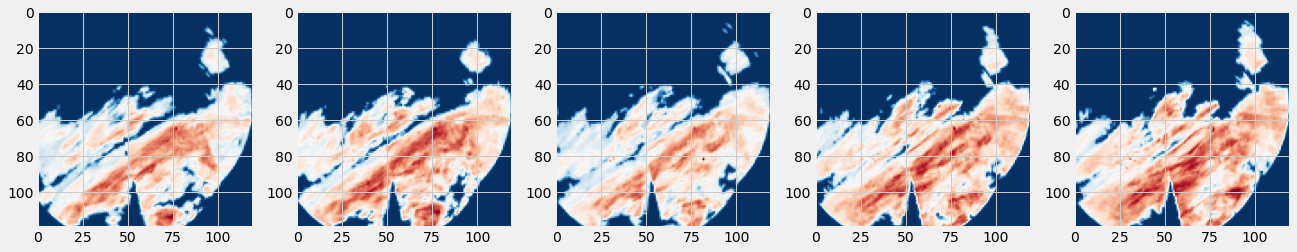

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20, 20))

for i in range(4):
    plt.subplot(1,5,i+1)
    plt.imshow(image_sample[:, :, i], cmap=color_map)

plt.subplot(1,5,5)
plt.imshow(image_sample[:,:,-1], cmap=color_map)
plt.show()

## 4. Define data generator function

In [ ]:
def trainGenerator():
    for file in tr_file:
        dataset = np.load(file)
        target= dataset[:,:,-1].reshape(120,120,1)        
        remove_minus = np.where(target < 0, 0, target)
        feature = dataset[:,:,:4]

        yield (feature, remove_minus)

def valGenerator():
    for file in val_file:
        dataset = np.load(file)
        target= dataset[:,:,-1].reshape(120,120,1)        
        remove_minus = np.where(target < 0, 0, target)
        feature = dataset[:,:,:4]

        yield (feature, remove_minus)

## 5. Modeling

### - CNN2D + U-Net

In [ ]:
def CNN_Unet_model(input_layer, start_neurons) :
    
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    pool1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    pool2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(pool2)

    convm = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation='relu')(uconv1)
    
    return output_layer

In [ ]:
# 5 Fold 훈련

kf = KFold(n_splits=5, random_state=42)

for fold, (train, val) in enumerate(kf.split(train_files)):

  tr_file = train_files[train]
  val_file = train_files[val]

  train_dataset = tf.data.Dataset.from_generator(trainGenerator, (tf.float32, tf.float32), (tf.TensorShape([120,120,4]),tf.TensorShape([120,120,1])))
  train_dataset = train_dataset.shuffle(len(tr_file)).batch(64).prefetch(1)   # , drop_remainder=True

  val_dataset = tf.data.Dataset.from_generator(valGenerator, (tf.float32, tf.float32), (tf.TensorShape([120,120,4]),tf.TensorShape([120,120,1])))
  val_dataset = val_dataset.batch(64).prefetch(1)


  input_layer = Input((120, 120, 4))
  output_layer = CNN_Unet_model(input_layer, 64)
  model = Model(input_layer, output_layer)

  # OPTIMIZER = tf.keras.optimizers.Adam()   # lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  model.compile(optimizer='Adam', loss='mae')

  callbacks = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=2, verbose=0, mode='min',
    min_delta=0.0001, cooldown=0, min_lr=0)

  sv = tf.keras.callbacks.ModelCheckpoint(
        os.path.join(path,f'{fold}-rain.h5'), monitor='val_loss', verbose=0, save_best_only=True,
        save_weights_only=True, mode='min', save_freq='epoch')

  history = model.fit(train_dataset, epochs=10, verbose=1, validation_data=val_dataset, callbacks=[callbacks, sv])

  del model
  gc.collect()

Epoch 1/10
785/785 [==============================] - 95s 121ms/step - loss: 4.6999 - val_loss: 3.2985
Epoch 2/10
785/785 [==============================] - 94s 119ms/step - loss: 3.2392 - val_loss: 3.2610
Epoch 3/10
785/785 [==============================] - 91s 116ms/step - loss: 3.0631 - val_loss: 3.0058
Epoch 4/10
785/785 [==============================] - 91s 116ms/step - loss: 2.9598 - val_loss: 2.9993
Epoch 5/10
785/785 [==============================] - 90s 115ms/step - loss: 2.9258 - val_loss: 3.5055
Epoch 6/10
785/785 [==============================] - 91s 116ms/step - loss: 2.8912 - val_loss: 2.9669
Epoch 7/10
785/785 [==============================] - 90s 115ms/step - loss: 2.8802 - val_loss: 2.9748
Epoch 8/10
785/785 [==============================] - 90s 115ms/step - loss: 2.8509 - val_loss: 2.9805
Epoch 9/10
785/785 [==============================] - 91s 116ms/step - loss: 2.8079 - val_loss: 2.9189
Epoch 10/10
785/785 [==============================] - 91s 116ms/step - l

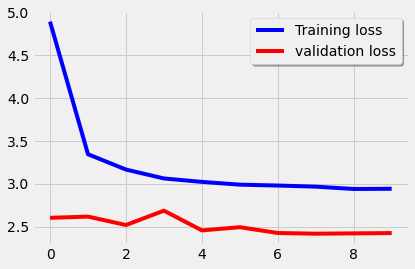

In [ ]:
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="validation loss")
plt.legend(loc='best', shadow=True)
plt.show()

In [ ]:
input_layer = Input((120, 120, 4))
output_layer = CNN_Unet_model(input_layer, 64)
model = Model(input_layer, output_layer)
model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 120, 120, 4) 0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 120, 120, 64) 2368        input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 120, 120, 64) 256         conv2d_30[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 60, 60, 64)   0           batch_normalization_20[0][0]     
______________________________________________________________________________________

In [ ]:
!pip install graphviz
!pip install pydot

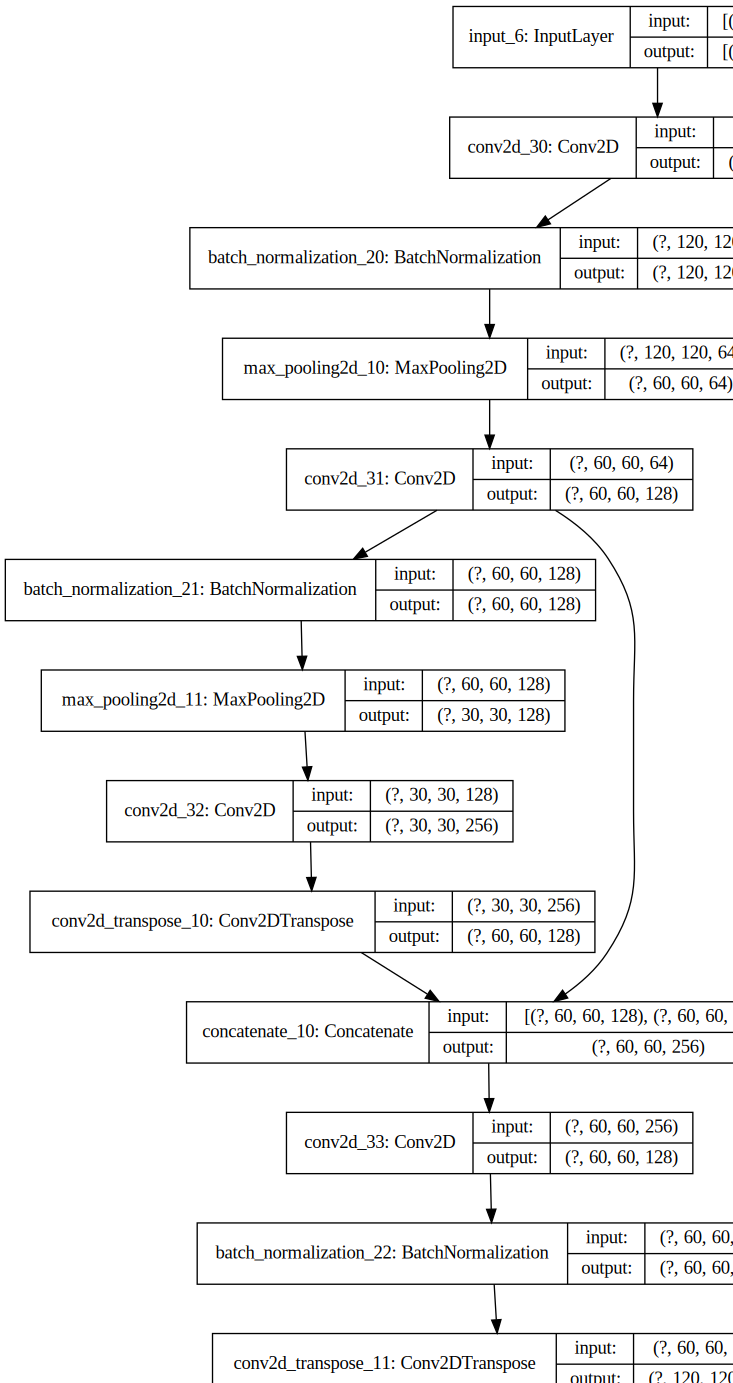

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

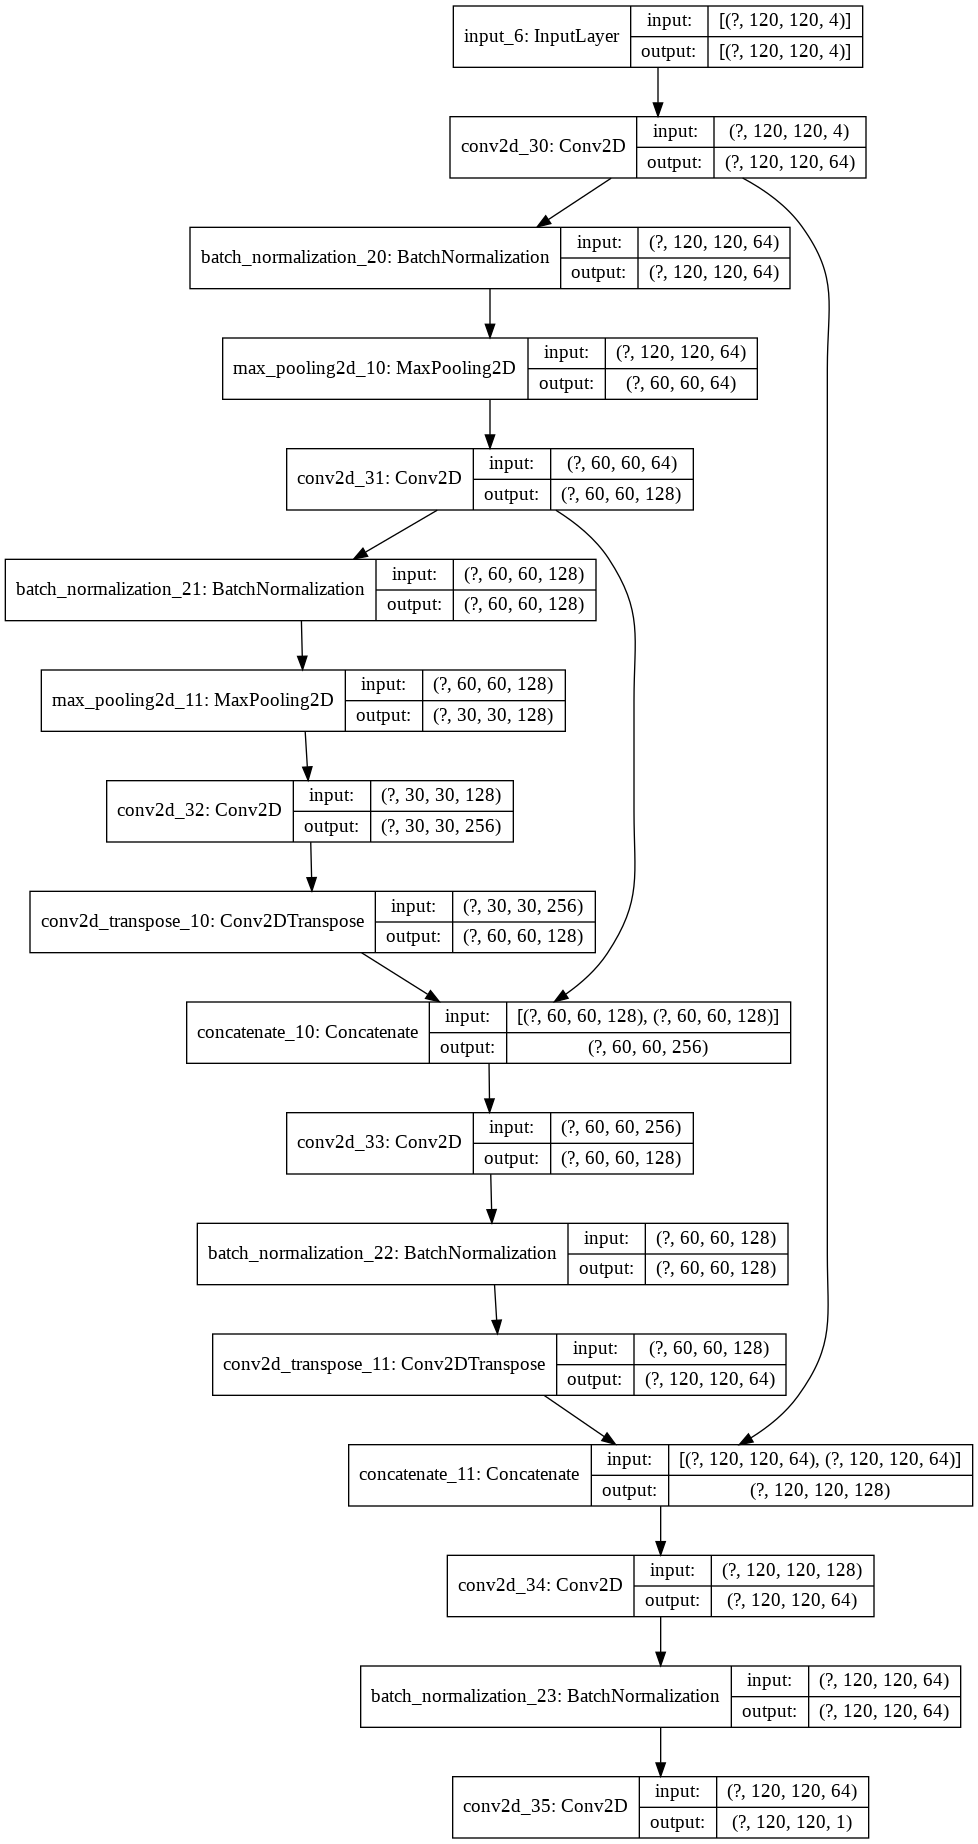

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='CNN_Unet_model.png', show_shapes=True, show_layer_names=True)

## 6. Define loss function for CV

In [ ]:
def loss(final_X_answers, final_X_pred):
  pred = final_X_pred
  answer = final_X_answers
  mae = mean_absolute_error(answer, pred)
  print(mae)

## 7. Load test data

In [ ]:
zip_file = zipfile.ZipFile(path+'/test.zip')
zip_file.extractall('.')

In [ ]:
test_files = sorted(glob.glob('test*.npy'))

X_test = []
for file in tqdm(test_files, desc = 'test'):
    data = np.load(file)
    X_test.append(data)

X_test = np.array(X_test)

test: 100%|██████████| 2674/2674 [00:00<00:00, 2754.82it/s]


## 8. Predict

In [ ]:
kf = KFold(n_splits=5, random_state=42)
total_val = []
total_answer = []
test_preds = []

for fold, (train, val) in enumerate(kf.split(train_files)):
  
  val_file = train_files[val]

  X_val = []
  X_answers = []
  
  for file in tqdm(val_file, desc='val'):
    data = np.load(file)
    X_answer = data[:,:,-1].reshape(14400)
    X_input = data[:,:,:4]
  
    X_val.append(X_input)
    X_answers.append(X_answer)
  X_val = np.array(X_val)
  X_answers = np.array(X_answers)
  model.load_weights(os.path.join(path,f'{fold}-rain.h5'))

  val_pred = model.predict(X_val)
  test_pred = model.predict(X_test)

  test_pred = test_pred.reshape(-1,14400)
  final_X_val = val_pred.reshape(-1,14400)
  total_val.append(final_X_val)
  total_answer.append(X_answers)
  test_preds.append(test_pred)
  
  del val_pred, X_val, X_answers, final_X_val
  gc.collect()

val: 100%|██████████| 12547/12547 [00:04<00:00, 3126.11it/s]


## 9. Cross Validation

In [ ]:
# 2.93 정도
final_val = np.reshape(np.array(total_val), (5*12547,14400))
final_answer = np.reshape(np.array(total_answer),(5*12547,14400))
loss(final_answer, final_val)

2.8410854


## 10. Create submission file

In [ ]:
# final_preds = (test_preds[0]+test_preds[1]+test_preds[2]+test_preds[3]+test_preds[4])/5
# sub = pd.read_csv("sample_submission.csv")
# sub.iloc[:,1:] = final_preds.astype(int)
# sub.to_csv("submission.csv", index=False)
# from google.colab import files
# files.download('submission.csv')